<center style="font-size:30px;padding-bottom:10px;color:DarkBlue;">Procesos Estocásticos</center>
<center> _____________________________________________________________________________________________ </center>
<p>&nbsp;</p>
<center style="font-size:25px;padding-bottom:10px;color:CornFlowerBlue;">Sistemas en Tiempo Continuo</center>
<center style="font-size:20px;padding-bottom:10px;color:LightCoral;">Ejercicios 1</center>
<center style="font-size:15px;">María Barroso Honrubia</center>
<center style="font-size:15px;">Gloria del Valle Cano</center>
<center style="font-size:12px;">17 de diciembre 2021</center>



In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import arrival_process_simulation as arrival
from scipy import stats, integrate, special
from BM_simulators import *
from stochastic_plots import *
from IPython.display import display, Math, Latex

---

### Ejercicio 1

*Se pide*
- *Demostrar que $P(N(t)=n)=\frac{1}{n!}\lambda^nt^ne^{-\lambda t}$*.
- *Simular un proceso de Poisson de parámetro $\lambda=10$ para $t=2$ y calcular la distribución empírica de $P(N(t)=n)$ para validar el resultado anterior.*

---

Para ello, vamos a comenzar desarrollando $P[N(t+\Delta t)=n]$ como una suma de las diferentes probabilidades de los sucesos posibles. Es decir:
- Hay $n$ sucesos al tiempo $t$ y a tiempo $t+\Delta$ no hay ningún suceso.
- Hay $n-1$ sucesos a tiempo $t$ y a tiemo $t+\Delta$ hay un suceso.
- ...
- No hay ningún suceso a tiempo $t$ y hay $n$ sucesos al tiempo $t+\Delta$.

Para simplificar la notación, vamos a considerar $P_{t;n}=P[N(t)=n]$ y $P_{\Delta t;n}=P[\Delta N(t)=n]$.

$$P_{t+\Delta t;n}= \sum_{i=0}^n P_{t;n-i}P_{\Delta t;i} = 
P_{t;n}P_{\Delta t;0} + P_{t;n-1}P_{\Delta t;1} + \sum_{i=2}^{n}P_{t;n-i}P_{\Delta t;i}
$$

Como $P_{\Delta t;0}=1-\lambda\Delta t + o(\Delta t)$, $P_{\Delta t;1}=\lambda\Delta t + o(\Delta t)$ y $P_{\Delta t;n\geq2} = o(\Delta t)$, la anterior expresión resulta en

$$
P_{t+\Delta t;n}=P_{t;n}(1-\lambda t) + P_{t;n-1}\lambda t + o(\Delta t),
$$

que puede reescribirse como:

$$P_{t+\Delta t;n}-P_{t;n}= -\lambda\Delta t P_{t;n} + P_{t;n-1}\lambda\Delta t + o(\Delta t)$$

Tomando el límite $\Delta t \to 0^+$, cada sumando tiende a 0 y puede utilizarse el límite $\Delta t \to 0$, obteniéndose la ecuación diferencial:

$$
\frac{d}{dt}P_{t;n} =  \lambda(-P_{t;n} + P_{t;n-1})
$$

Puede comprobarse que $\frac{1}{n!} \lambda^n t^n e^{-\lambda t}$ es solución de la EDO, esto es, que su derivada respecto a $t$ coincide con la anterior expresión y que se cumple la condición inicial $P_{0;0}=1$.

$$\begin{aligned}
\frac{d}{dt} \left(\frac{1}{n!} \lambda^n t^n e^{-\lambda t}\right) &= \frac{\lambda^n}{n!} \left(n t^{n-1}e^{-\lambda t} - \lambda t^ne^{-\lambda t}\right) \\
&= \frac{1}{(n-1)!} \lambda^n t^{n-1} e^{-\lambda t} - \frac{1}{n!} \lambda^{n+1} t^n e^{-\lambda t} \\
&= \lambda \left(\frac{1}{(n-1)!} \lambda^{n-1} t^{n-1} e^{-\lambda t} - \frac{1}{n!} \lambda^n t^n e^{-\lambda t}\right) \\
&= \lambda\left( P_{n-1} - P_n \right) \\
\\
\frac{1}{n!} \lambda^n t^n e^{-\lambda t} &= 1 \text{ para } n=t=0.
\end{aligned}$$


A continuación, resolveremos la EDO utilizando inducción, pero antes conviene introducir el factor $e^\lambda t$ en la expresión:

$$
\frac{d}{dt}\left(e^{\lambda t}P_{t;n}\right) =  \lambda e^{\lambda t} P_{t;n} + e^{\lambda t}\frac{d}{dt}P_{t;n} = \lambda e^{\lambda t} P_{t;n} +e^{\lambda t}\lambda\left(-P_{t;n} + P_{t;n-1}\right) = \lambda P_{t;n-1} e^{\lambda t}
$$

Para $n=0$, podemos resolverla facilmente utilizando que $P_{t;0}=e^{-\lambda t}$ (prueba en el enunciado del ejercicio)

$$
\frac{d}{dt}\left(e^{\lambda t}P_{t;0}\right) = \frac{d}{dt}\left(e^{\lambda t}e^{-\lambda t}\right) = 0
$$

Para $n=1$
$$
\frac{d}{dt}\left(e^{\lambda t}P_{t;1}\right) = \lambda P_{t;0} e^{\lambda t} = \lambda e^{-\lambda t} e^{\lambda t} = \lambda \implies e^{\lambda t}P_{t;1} = \int_0^t \lambda d\tau= \lambda t
$$

Para $n=2$
$$
\frac{d}{dt}\left(e^{\lambda t}P_{t;2}\right) = \lambda e^{\lambda t} P_{t;1}  = \lambda^2 t \implies e^{\lambda t}P_{t;2} = \int_0^t \lambda^2 \tau d\tau = \frac{1}{2}\lambda\tau
$$

Utilizando inducción, se demuestra que:

$$\begin{aligned}
e^{\lambda t}P_{t;n}&=\frac{1}{n!}\lambda^nt^n\\
P_{t;n}&=\frac{1}{n!}\lambda^nt^ne^{-\lambda t}
\end{aligned}$$

En segundo lugar, vamos a realizar una simulación del proceso de Poisson, y se comparará con la distribución teórica.

In [18]:
def poisson_pmf_est_theo(lambda_rate, M, T, t0, t1):
    """ Simulates Poisson distribution and computes theoretical PMF

        P_{t;n} = (1/n!) * lambda^n * t^n * e^(-\lambda*t)

    Parameters
    ----------
    lambda_rate : int
        Lambda poisson parameter
    M : int
        Number of steps for the simulation
    T : float
        Length of the simulation
    t0 : float
        Initial time for the simulation
    t1 : float
        Time for the simulation

    Returns
    -------
    pmf_est : numpy.ndarray
        PMF Poisson estimated value
    pmf_theo : numpy.ndarray
        PMF Poisson theoretical value

    Example
    -------
    >>> import arrival_process_simulation as arrival
    >>> from scipy import stats, integrate, special
    >>> lambda_rate, T, M = 10, 41, 50000
    >>> t0, t1 = 0., 2.
    >>> pmf_est, pmf_theo = poisson_pmf_est_theo(lambda_rate, M, T, t0, t1)

    """
    # Simulated distribution
    arrival_times = arrival.simulate_poisson(t0, t1, lambda_rate, M)
    N = np.array([len(a) for a in arrival_times])
    pmf_est = np.bincount(N, minlength=T)/M

    # Theoretical distribucion
    X = np.arange(len(pmf_est))
    pmf_theo = (lambda_rate*t1)**X * np.exp(-lambda_rate*t1) / special.factorial(X)
    
    return pmf_est, pmf_theo

def plot_poisson_pmf(lambda_rate, M, T, t0, t1):
    """ Plots Poisson distribution and theoretical PMF

    Parameters
    ----------
    lambda_rate : int
        Lambda poisson parameter
    M : int
        Number of steps for the simulation
    T : float
        Length of the simulation
    t0 : float
        Initial time for the simulation
    t1 : float
        Time for the simulation
    
    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> import arrival_process_simulation as arrival
    >>> from scipy import stats, integrate, special
    >>> lambda_rate, T, M = 10, 41, 50000
    >>> t0, t1 = 0., 2.
    >>> plot_poisson_pmf(lambda_rate, M, T, t0, t1)
    
    """
    # Get PMF estimation and theoretical value
    pmf_est, pmf_theo = poisson_pmf_est_theo(lambda_rate, M, T, t0, t1)
    X = np.arange(len(pmf_est))
    
    # Plot
    width = 0.35
    plt.figure(figsize=(15, 8))
    plt.title('Poisson Process Simulation vs Probability Density')
    plt.bar(X-width, pmf_theo, color='royalblue', width=width, label='Theoretical', align='center')
    plt.bar(X, pmf_est, color='plum', width=width, label='Simulation', align='center')
    plt.xlabel(f'$n$ events')
    plt.ylabel(f'$P(N(2)=n)$')
    plt.legend()
    plt.show()

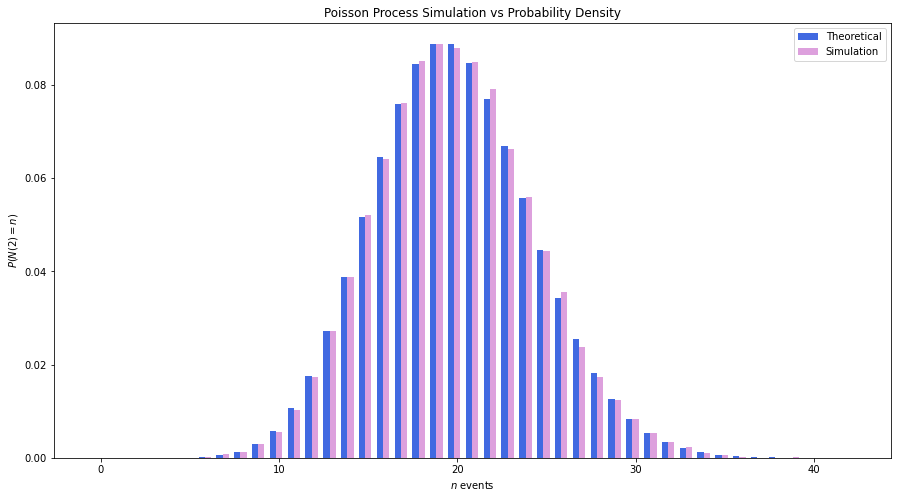

In [19]:
# Parameters of the Poisson process
lambda_rate, T, M = 10, 41, 50000
t0, t1 = 0., 2.

# Plot PMF
plot_poisson_pmf(lambda_rate, M, T, t0, t1)

---
### Ejercicio 2

*Se pide simular un proceso de Poisson de parámetro $\lambda=5$ y mostrar que las distribuciones empíricas del primer, segundo, quinto y décimo evento siguen la distribución teórica Erlang*
$$f_{S_n}(t)=\frac{\lambda^n t^{n-1} e^{-\lambda t}}{(n-1)!}$$

---

In [25]:
def erlang(t, n, lambda_rate):
    """ Computes Erlang PDF

        f_{S_n}(t)= lambda^n * t^(n-1) * e^(-lambda*t) / (n-1)!
    
    Parameters
    ----------
    t : float
        Given t value for Erlang
    n : int
        Ghape factor for Erlang PMF
    lambda_rate : float
        Lambda parameter for Erlang PMF
    
    Returns
    -------
    numpy.ndarray
        Erlang PDF theoretical value

    """
    return lambda_rate**n * t**(n-1)* np.exp(-lambda_rate*t) / special.factorial(n-1)

def plot_poisson_erlang(lambda_rate, M, N, t0, t1):
    """ Plots Poisson distribution and theoretical PMF

    Parameters
    ----------
    lambda_rate : int
        Lambda poisson parameter
    M : int
        Number of steps for the simulation
    N : numpy.array
        Given events for the simulation
    T : float
        Length of the simulation
    t0 : float
        Initial time for the simulation
    t1 : float
        Time for the simulation
    
    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> import arrival_process_simulation as arrival
    >>> from scipy import stats, integrate, special
    >>> lambda_rate, T, M, N = 10, 5, 50000, N = np.array([1, 2, 5, 10])
    >>> t0, t1 = 0., 7.
    >>> plot_poisson_erlang(lambda_rate, M, N, T, t0, t1)
    
    """

    # Poisson simulation
    arrival_times = arrival.simulate_poisson(t0, t1, lambda_rate, M)
    arrival_n = [[a[n-1] for a in arrival_times] for n in N]

    # Theoretical density (Erlang)
    ts = np.linspace(0, t1, 100)
    f_sn = [erlang(ts, n, lambda_rate) for n in N]

    # Plots
    fig, axs = plt.subplots(2, 2, figsize=(18, 14))
    axs = axs.flatten()
    for i in range(4):
        axs[i].hist(arrival_n[i], color='cornflowerblue', density=True, bins=50, label='Simulation', alpha=0.5)
        axs[i].plot(ts, f_sn[i], color='indigo', label = 'Erlang')
        axs[i].set_xlabel('$s_{' + str(N[i]) +'}$')
        axs[i].set_ylabel('pdf$(s_{' + str(N[i]) + '})$')
        axs[i].set_title(f'Density of {N[i]} arrival')
        axs[i].legend()


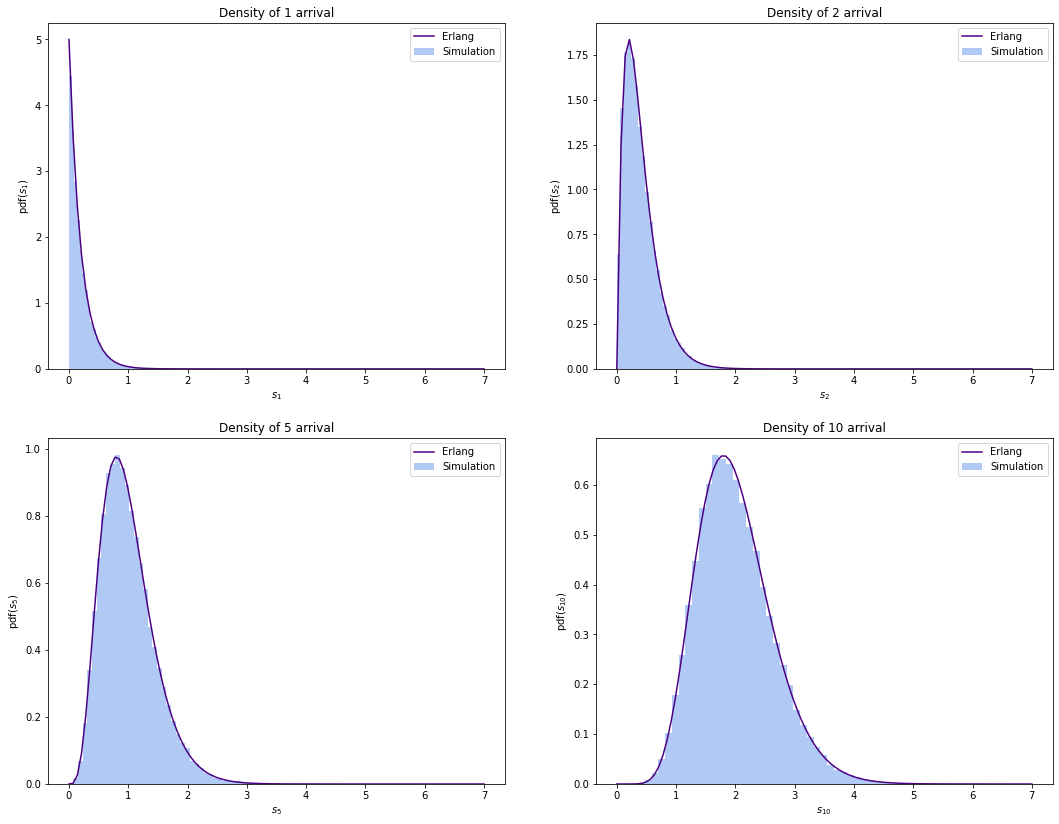

In [26]:
lambda_rate, M, N = 5., 50000, np.array([1, 2, 5, 10])
t0, t1 = 0., 7.

plot_poisson_erlang(lambda_rate, M, N, t0, t1)

---

### Ejercicio 3

*Sea $\{N(t);t\geq 0\}$ un proceso de Poisson de razón $\lambda$. Se pide demostrar que la distribución de los tiempo entre llegadas $\{0<S_1<S_2<...<S_n\}$ condicionada a $N(t)=n$ coincide con la distribución del estadístico de orden de $n$ variables aleatorias i.i.d $U[0,t]$*
$$f_{\{S_{i}\}_{i=1}^n|N(t)}(\{s_i\}_{i=1}^n|n)=f_{\{U_{(i)}\}_{i=1}^n}=\frac{n!}{t^n}$$

---

Para ello, en primer lugar se va a utilizar el teorema de Bayes para calcular la densidad

$$
f_{\{S_{i}\}_{i=1}^{n+1}|N(t)}(\{s_i\}_{i=1}^{n+1}|n) = \frac{f_{\{S_{i}\}_{i=1}^{n+1}}(\{s_i\}_{i=1}^{n+1})f_{N(t)|\{S_i\}_{i=1}^{n+1}}(n|\{s_i\}_{i=1}^{n+1})}{f_{N(t)}(n)}
$$

Antes de desarollar las probabilidades de arriba, conviene darse cuenta de que $N(t)=n\Longleftrightarrow	s_n\leq t < s_{n+1}$, ya que

$$ f_{N(t)|\{S_i\}_{i=1}^{n+1}}(n|\{s_i\}_{i=1}^{n+1}) =  \begin{cases}
1  & s_n\leq t <s_{n+1} \\
 0 & \text{fotherwise}
\end{cases}$$

Por tanto, solo nos ocuparemos del caso $s_n\leq t < s_{n+1}$.

Ademas, $f_{\{S_{i}\}}$ sigue una distribución exponencial de parámetro $\lambda$ con $S_i$ i.i.d, luego, la expresión anterior resultado de aplicar Bayes resulta en

$$\begin{aligned}
f_{\{S_{i}\}_{i=1}^{n+1}|N(t)}(\{s_i\}_{i=1}^{n+1}|n) &= \frac{f_{\{S_{i}\}_{i=1}^{n+1}}(\{s_i\}_{i=1}^{n+1})}{f_{N(t)}(n)}\\
&=\frac{\lambda^{n+1}e^{\lambda s_{n+1}}}{\lambda^n t^n e^{-\lambda t}/n!} \\
&= \frac{\lambda e^{-\lambda(s_{n+1}-t)}n!}{t^n}
\end{aligned}$$


Por otro lado, $f_{\{S_{i}\}_{i=1}^{n+1}|N(t)}$ puede reescribirse como

$$f_{\{S_{i}\}_{i=1}^{n+1}|N(t)}(\{s_i\}_{i=1}^{n+1}|n) = f_{S_{n+1}|\{S_i\}_{i=1}^n,N(t)}(s_{n+1}|\{s_i\}_{i=1}^n,n)f_{\{S_i\}_{i=1}^n|N(t)}(\{s_i\}_{i=1}^n|n)$$

Y utilizando la propiedad de que los tiempos entre llegadas son un proceso sin memoria, para $s_{n+1}>t$, se tiene que

$$f_{S_{n+1}|\{S_i\}_{i=1}^n,N(t)}(s_{n+1}|\{s_i\}_{i=1}^n,n) = f_{S_{n+1}|N(t)}(s_{n+1}|n)$$

Utilizando esta propiedad y despejando $f_{\{S_i\}_{i=1}^n|N(t)}$ de la expresión, finalmente se prueba que

$$\begin{aligned}
f_{\{S_i\}_{i=1}^n|N(t)}(\{s_i\}_{i=1}^n|n) &= \frac{f_{\{S_{i}\}_{i=1}^{n+1}|N(t)}(\{s_i\}_{i=1}^{n+1}|n)}{f_{S_{n+1}|N(t)}(s_{n+1}|n)}\\
&=\frac{\lambda e^{-\lambda(s_{n+1}-t)}n!/t^n}{\lambda e^{-\lambda(s_{n+1}-t)}} \\ &= \frac{n!}{t^n}
\end{aligned}$$



---

### Ejercicio 4

*Sea $N_1\sim \mbox{Poisson}(\lambda_1=0.02)$ y $N_2\sim\mbox{Poisson}(\lambda_1=0.03)$. Sea $N=N_1+N_2\sim\mbox{Poisson}(\lambda)$ y considerádose $t\in[0,90]$, se pide calcular teóricamente y mediante simulación:*

1. $P(N(90)=0)$
2. $P(N(90)\geq 2)$
3. $P(N_1(90)=1, N_2(90)=2)$
4. $P(N_1(90)=N_2(90))$
5. $P(S_1^{(N_2)}<S_1^{(N_1)})$, donde $S_1^{N_2}$ representa el tiempo del primer suceso del proceso $N_2$ y $S_1^{N_1}$ representa el tiempo del primer suceso del proceso $N_1$.

---


En primer lugar vamos a calcular el parámetro $\lambda$ de la suma de las dos v.a. de Poisson, que es igual a la suma de los parámetros de cada v.a. Es decir,  $$N=N_1+N_2\sim\mbox{Poisson}(\lambda=\lambda_1+\lambda_2=0.01)$$ 

Teóricamente,
- $P(N(90)=0)= e^{-90\lambda} \sim 0.011108$.

- $P(N(90)\geq 2)= 1-P(N(90)=1)-P(N(90)=0)= 1 - 90\lambda e^{-90\lambda}-P(N(90)=0) \sim 0.9389$.

- $P(N_1(90)=1, N_2(90)=2)=P(N_1(90)=1)P(N_2(90)=2) = 90\lambda_1 e^{-90\lambda_1}\frac{90\lambda_2 e^{-90\lambda_2}}{2!} \sim 0.07288$.

- $N'=N_1-N_2\sim \mbox{Skellam}(\lambda_1,\lambda_2)$, cuya pmf es $$P(N'(t)=n)=e^{-t(\lambda_1+\lambda_2)}\frac{\lambda_1}{\lambda_2}^nI_n(2t\sqrt{\lambda_1\lambda_2})$$ donde $I_n$ es la función de Bessel modificada. Por tanto, 
$$P(N_1(90)=N_2(90)) = P(N_1(90)-N_2(90)=0) = P(N'(90)=0) = e^{-90(\lambda_1+\lambda_2)}I_0(180\sqrt{\lambda_1\lambda_2}) \sim 0.5933$$

- $P(S_1^{(N_2)}<S_1^{(N_1)})=\int_{0}^{90}P(S_1^{(N_1)}>t|f_{S^{N_2}}(t))f_{S^{N_2}}(t)dt = \int_{0}^{90}P(S_1^{(N_1)}>t)f_{S^{N_2}}(t)dt = \int_{0}^{90}e^{-\lambda_1 t}\lambda_2e^{-\lambda_2 t}dt \sim 0.5933$

A continuación procedemos a realizar las distintas simulaciones y a contrastar los resultados con los valores teóricos.

In [43]:
# Parameters of the Poisson process
t0 = 0.0
t1 = 90.0
lambda_rate_1 = 0.02
lambda_rate_2 = 0.03
lambda_rate = lambda_rate_1 + lambda_rate_2
M = 50000

# Simulation arrival times N1 y N2
arrival_times_1 = arrival.simulate_poisson(t0, t1, lambda_rate_1, M)
arrival_times_2 = arrival.simulate_poisson(t0, t1, lambda_rate_2, M)

# Get N1, N2 y N=N1+N2
N1 = np.array([len(a) for a in arrival_times_1])
N2 = np.array([len(a) for a in arrival_times_2])
N = N1 + N2

* $P(N(90) = 0)$

In [48]:
p0_est = sum(N==0)/M
display(Latex(f'Estimated: $P(N(90)=0)$ = {p0_est:.4f}'))

p0_theo = stats.poisson.pmf(0.0, lambda_rate*t1)
display(Latex(f'Theoretical: $P(N(90)=0)$ = {p0_theo:.4f}'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

* $P(N(90)>=2)$

In [49]:
p2_est = sum(N>=2)/M
display(Latex(f'Estimated: $P(N(90)>=2)$ = {p2_est:.4f}'))

p2_theo = 1-stats.poisson.cdf(1.0, lambda_rate*t1)
display(Latex(f'Theoretical: $P(N(90)>=2)$ = {p2_theo:.4f}'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

* $P(N_1(90)=1,N_2(90)=2)$

In [53]:
p_est = sum((N1==1) & (N2==2))/M
display(Latex(f'Estimated: $P(N_1(90)=1,N_2(90)=2)$ = {p_est:.4f}'))

p_theo = stats.poisson.pmf(1.0, lambda_rate_1*t1)*stats.poisson.pmf(2.0, lambda_rate_2*t1)
display(Latex(f'Theoretical: $P(N_1(90)=1,N_2(90)=2)$ = {p_theo:.4f}'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

* $P(N_1(90)=N_2(90))$

In [51]:
p_est = sum(N1==N2)/M
display(Latex(f'Estimated: $P(N_1(90)=N_2(90))$ = {p_est:.4f}'))

p_theo = np.exp(-t1*lambda_rate)*special.iv(0, 2*t1*np.sqrt(lambda_rate_1*lambda_rate_2))
display(Latex(f'Theoretical: $P(N_1(90)=N_2(90))$ = {p_theo:.4f}'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

* $P(S_1^{N_2}<S_1^{N_1})$

In [54]:
p_est = 0
for m in range(M):
    if N2[m] > 0 and (N1[m]==0 or arrival_times_2[m][0] < arrival_times_1[m][0]):
        p_est +=1
        
p_est /= M
display(Latex(f'Estimated: $P(S_2>S_1)$ = {p_est:.4f}'))

p_theo = integrate.quad(lambda t: lambda_rate_2*np.exp(-lambda_rate*t), t0, t1)[0] # analytically solvable
display(Latex(f'Theoretical: $P(S_2>S_1)$ = {p_theo:.4f}'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---
### Ejercicio 5

Considerar el proceso $X(t) = Z\sqrt{t}$ para $t≥0$ con el mismo valor de $Z$ para todo $t$.

---

**a)** Ver que la distribución del proceso en tiempo $t$ es la misma que la de un proceso de Wiener: $X(t) \sim N(0, \sqrt(t))$.

Para un tiempo fijo $\bar t$, $Z \sim N(0,1)$, luego $X( \bar t)$ seguirá la distribución $Z\sqrt{\bar t}$, por tanto, $X(t) \sim N(0, \sqrt(t))$, por lo que es un proceso de Wiener.

In [13]:
def simulate_wiener(t0, T, M, N):
    """
    """
    t = np.linspace(t0, t0+T, N+1)          # grid
    Z = np.random.randn(M).reshape(M, 1)    # gausssian white noise
    sqrt_t = np.sqrt(t).reshape(1, N+1)
    return t, np.dot(Z, sqrt_t)

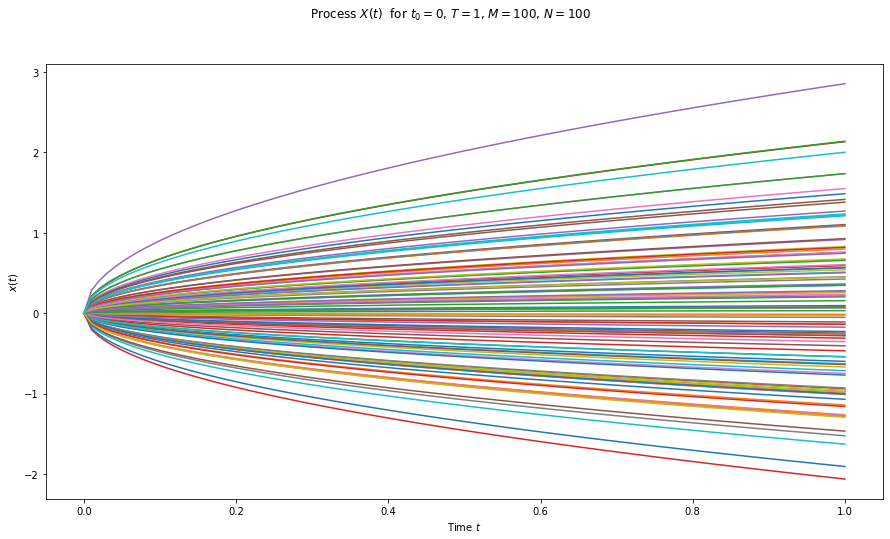

In [14]:
# Simulation parameters
t0 = 0          # initial time
T = 1           # length of the simulation
M = 100         # number of trajectories
N = 100         # number of steps for the simulation

# Simulation
t, X = simulate_wiener(t0, T, M, N)

# Plot
fig, ax = plt.subplots(1, figsize=(15, 8))
fig.suptitle('Process $X(t)$  for $t_0 = 0$, $T = 1$, $M = 100$, $N = 100$')
ax.plot(t, X.T)
ax.set_xlabel('Time $t$')
ax.set_ylabel('$x(t)$')
plt.show()

**b)** ¿Cuál es la propiedad matemática que nos permite probar que no se trata de un proceso Browniano?

$X(t)$ no es un proceso de Wiener debido a la dependencia de los incrementos. Sea $x(t)$ la trayectoria del proceso $X(t)$ y $z$ un valor extraído de una variable aleatoria gaussiana, $x(t) = z\sqrt{t}, \;\;\; \forall t ≥ 0$. Por tanto, si consideramos que $t_1 < t_2 < t_3 < t_4$, entonces $X(t_2)-X(t_1) = z(\sqrt{t_2} - \sqrt{t_1})$ y $X(t_4)-X(t_3) = z(\sqrt{t_4} - \sqrt{t_3})$ y no hay independencia entre ellos, ya que $X(t_4)-X(t_3) = X(t_2)-X(t_1)$ si $\sqrt{t_1} + \sqrt{t_3} = \sqrt{t_2} + \sqrt{t_4}$.

---

### Ejercicio 6

Considera el proceso de Wiener (standard Brownian) $W(t)$ in $[0,1]$,

---

**a)** Para la propiedad de los incrementos independientes:

$$
\mathbb{E}[(W(t_2) - W(t_1))(W(s_2) - W(s_1))] = \mathbb{E}[(W(t_2) - W(t_1))]\mathbb{E}[(W(s_2) - W(s_1))], \;\; t_2 ≥ t_1 ≥ s_2 ≥ s_1 ≥ 0,
$$

mostrar que las autocovarianzas están dadas por

$$
\gamma(t,s) = \mathbb{E}[W(t)W(s)] = min(s,t),
$$
ambos para $s>t$ y para $t>s$.

Dado $0 < s < t$, entonces $W(t) - W(s)$ y $W(s)-W(0)$ son variables aleatorias independientes normalmente distribuidas con media 0. Por la propiedad de los incrementos:

$$
\mathbb{E}[(W(t) - W(s))(W(s) - W(0))] = \mathbb{E}[(W(t) - W(s))]\mathbb{E}[(W(s) - W(0))] = 0
$$

Como $W(0)=0$, entonces $\mathbb{E}[W(t)W(s)-W(s)^2] = 0$ y

$$
\mathbb{E}[W(t)W(s)] = \underbrace{E[W(s)^2]}_{Var(W(s))} = s
$$

De manera análoga para $0 < t < s$, $\mathbb{E}[W(t)W(s)] = t$. Luego,

$$\gamma(t,s) = \mathbb{E}[W(t)W(s)] = min(s,t),
$$

**b)** Ilustrar esta propiedad simulando un proceso de Wiener en $[0,1]$ y hacer una gráfica de la estimación y de los valores teóricos de $\gamma(t, 0.25)$ como función de $t \in [0,1]$.

In [15]:
def gamma(r, s, t0, B, T):
    """
    Returns [0,1] cov matrix
    """
    # if r <= (T+t0) and r >= t0 ; s <= (T+t0) and s >= t0
    n = len(B[0]) - 1           # number of time intervals
    i_r = int((r-t0)*n/T)       # idx r
    i_s = int((s-t0)*n/T)       # idx s

    return np.cov(B[:, i_r], B[:, i_s])[0,1]

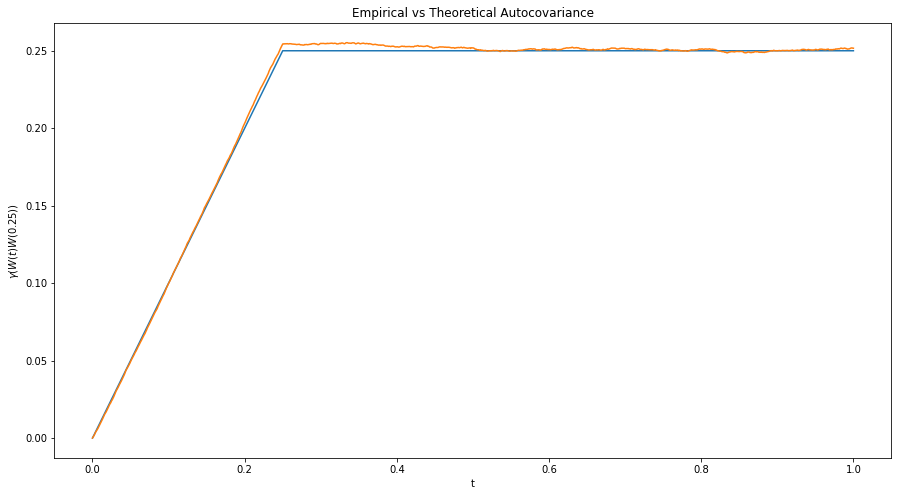

In [16]:
# Simulation parameters
mu, sigma = 0, 1    # gaussian parameters
M = 10000           # number of trajectories
N = 1000            # number of time steps
T = 1.              # length of simulation

# Initial conditions
t0 = 0.
B0 = 0

# Simulation
t, B = simulate_arithmetic_BM(t0, B0, T, mu, sigma, M, N)

# Time simulation
time = 0.25

# Compute empirical and theoretical value
empirical = [gamma(i, time, 0, B, T) for i in t]
theoretical = np.where(t < time, t, time)

# Plots
plt.figure(figsize=(15,8))
plt.plot(t, theoretical, label="Theoretical value")
plt.plot(t, empirical, label="Empirical value")
plt.xlabel('t')
plt.ylabel('$\gamma(W(t)W(0.25))$')
plt.title('Empirical vs Theoretical Autocovariance')
plt.show()

---
### Ejercicio 7

Considerar dos procesos de Wiener independientes, $W(t), W'(t)$. Mostrar que los siguientes procesos tienen la misma covarianza que un proceso de Wiener estándar.

---

**a)** $V_1(t) = pW(t) + \sqrt{1 - \rho^2}W'(t) \;\;\; t ≥ 0$

**b)** $V_2(t) = -W(t) t ≥ 0 $

**c)** $V_3(t) = \sqrt{c}W(t/c)$; $\;\;\; t≥0, c≥0$

**d)** $V_4(0) = 0; V_4(t) = tW(1/t), t>0$

Utilizaremos la propiedad $\mbox{Cov}(W(t)W(s))=\mathbb{E}[W(t)W(s)]$ de los procesos Wiener, que cumple para $0\leq t < s$, $\mathbb{E}[W(t)W(s)]=t$. Por tanto, demostrar que todos los procesos tienen la misma covarianza de un proceso de Wiener estándar es equivalente a probar que su  $\mathbb{E}[W(t)W(s)]=t$.

**a)** 

$$
\begin{align}
    \mathbb{E}(V_1(t)V_1(s)) &= \rho \mathbb{E}[W(t)W(s)] + \rho \sqrt{1 - \rho^2} \mathbb{E}[W(t)W'(s)] + \rho \mathbb{E}[W'(t)W(s)] +  \sqrt{1-\rho^2}  \mathbb{E}[W'(t)W(s)] \\
        &= \rho^2t + (1-\rho)^2t = t
\end{align}
$$


**b)**

$$
\begin{align}
    \mathbb{E}(V_2(t)V_2(s)) &= \mathbb{E}((-W(t))(-W(s))) = -(-t) = t
\end{align}
$$


**c)**
$$
\begin{align}
    \mathbb{E}(V_3(t)V_3(s)) &= c\mathbb{E}(W(t/c)(W(s/c)) = \frac{ct}{c} = t
\end{align}
$$

**d)**

$$
\begin{align}
    \mathbb{E}(V_4(t)V_4(s)) &= ts\mathbb{E}(W(1/t)(W(1/s)) \\&= ts \; \text{min} (1/t, 1/s)= \frac{ts}{s}= t
\end{align}
$$

Pintar unas gráficas de las trayectorias de los tres primeros procesos para ilustrar que son brownianos. Comparar el histograma con los valores finales de las trayectorias de la simulación con la función de densidad teórica.

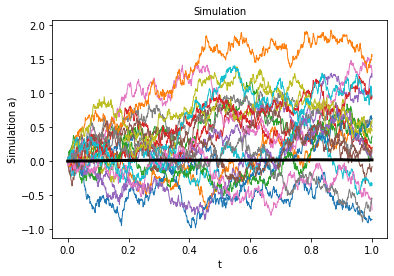

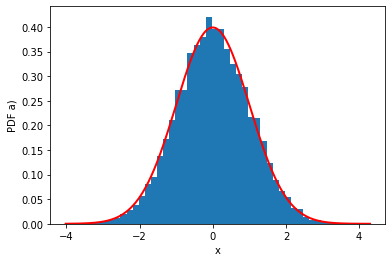

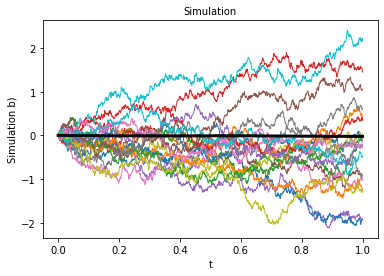

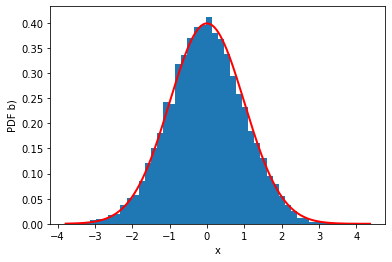

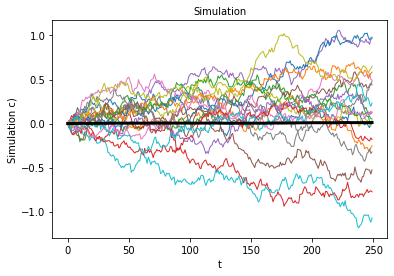

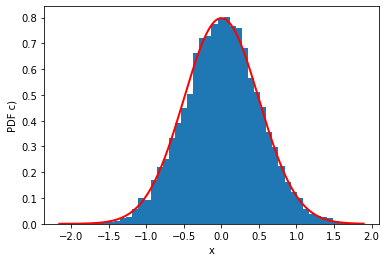

In [17]:
# Simulation parameters
mu, sigma = 0, 1    # gaussian parameters
M = 10000           # number of trajectories
N = 1000            # number of time steps
T = 1.              # length of simulation

# Initial conditions
t0 = 0.
B0 = 0

# Simulation
t, W = simulate_arithmetic_BM(t0, B0, T, mu, sigma, M, N)
_, W_ = simulate_arithmetic_BM(t0, B0, T, mu, sigma, M, N)

# Exercise parameters
rho = 0.5
c = 0.25
A = rho*W + np.sqrt(1 - rho**2)*W_
B = -W
C = np.sqrt(c)*W[:, np.arange(0, 1000, int(1/c))]

# Plots
examples = [A, B, C]
Ts = [T, T, c]
times = [t, t, np.arange(C.shape[1])]
labels = ['a)', 'b)', 'c)']

for i in range(3):
    plot_trajectories(times[i], examples[i])
    plt.ylabel("Simulation " + labels[i])
    plt.show()
    def pdf(f): 
        return stats.norm.pdf(f, B0 + mu*Ts[i], sigma*np.sqrt(Ts[i]))
    plot_pdf(examples[i][:,-1], pdf)
    plt.ylabel("PDF " + labels[i])
    plt.show()


---
### Extra

Hacer una animación en Python ilustrando la evolución de un proceso Browniano empezando en $x_0$:

$$
\mathbb{P}(B(t)=x|B(t_0)=x_0)
$$

Simular $M$ trayectorias del proceso en el intervalo $[t_0, t_0 + T ]$ y graficar la evolución en el tiempo del histograma usando como franjas un grid espaciado. Pintar el valor teórico de la función de densidad en la misma gráfica para poder compararla con el histograma.

---

<IPython.core.display.Javascript object>


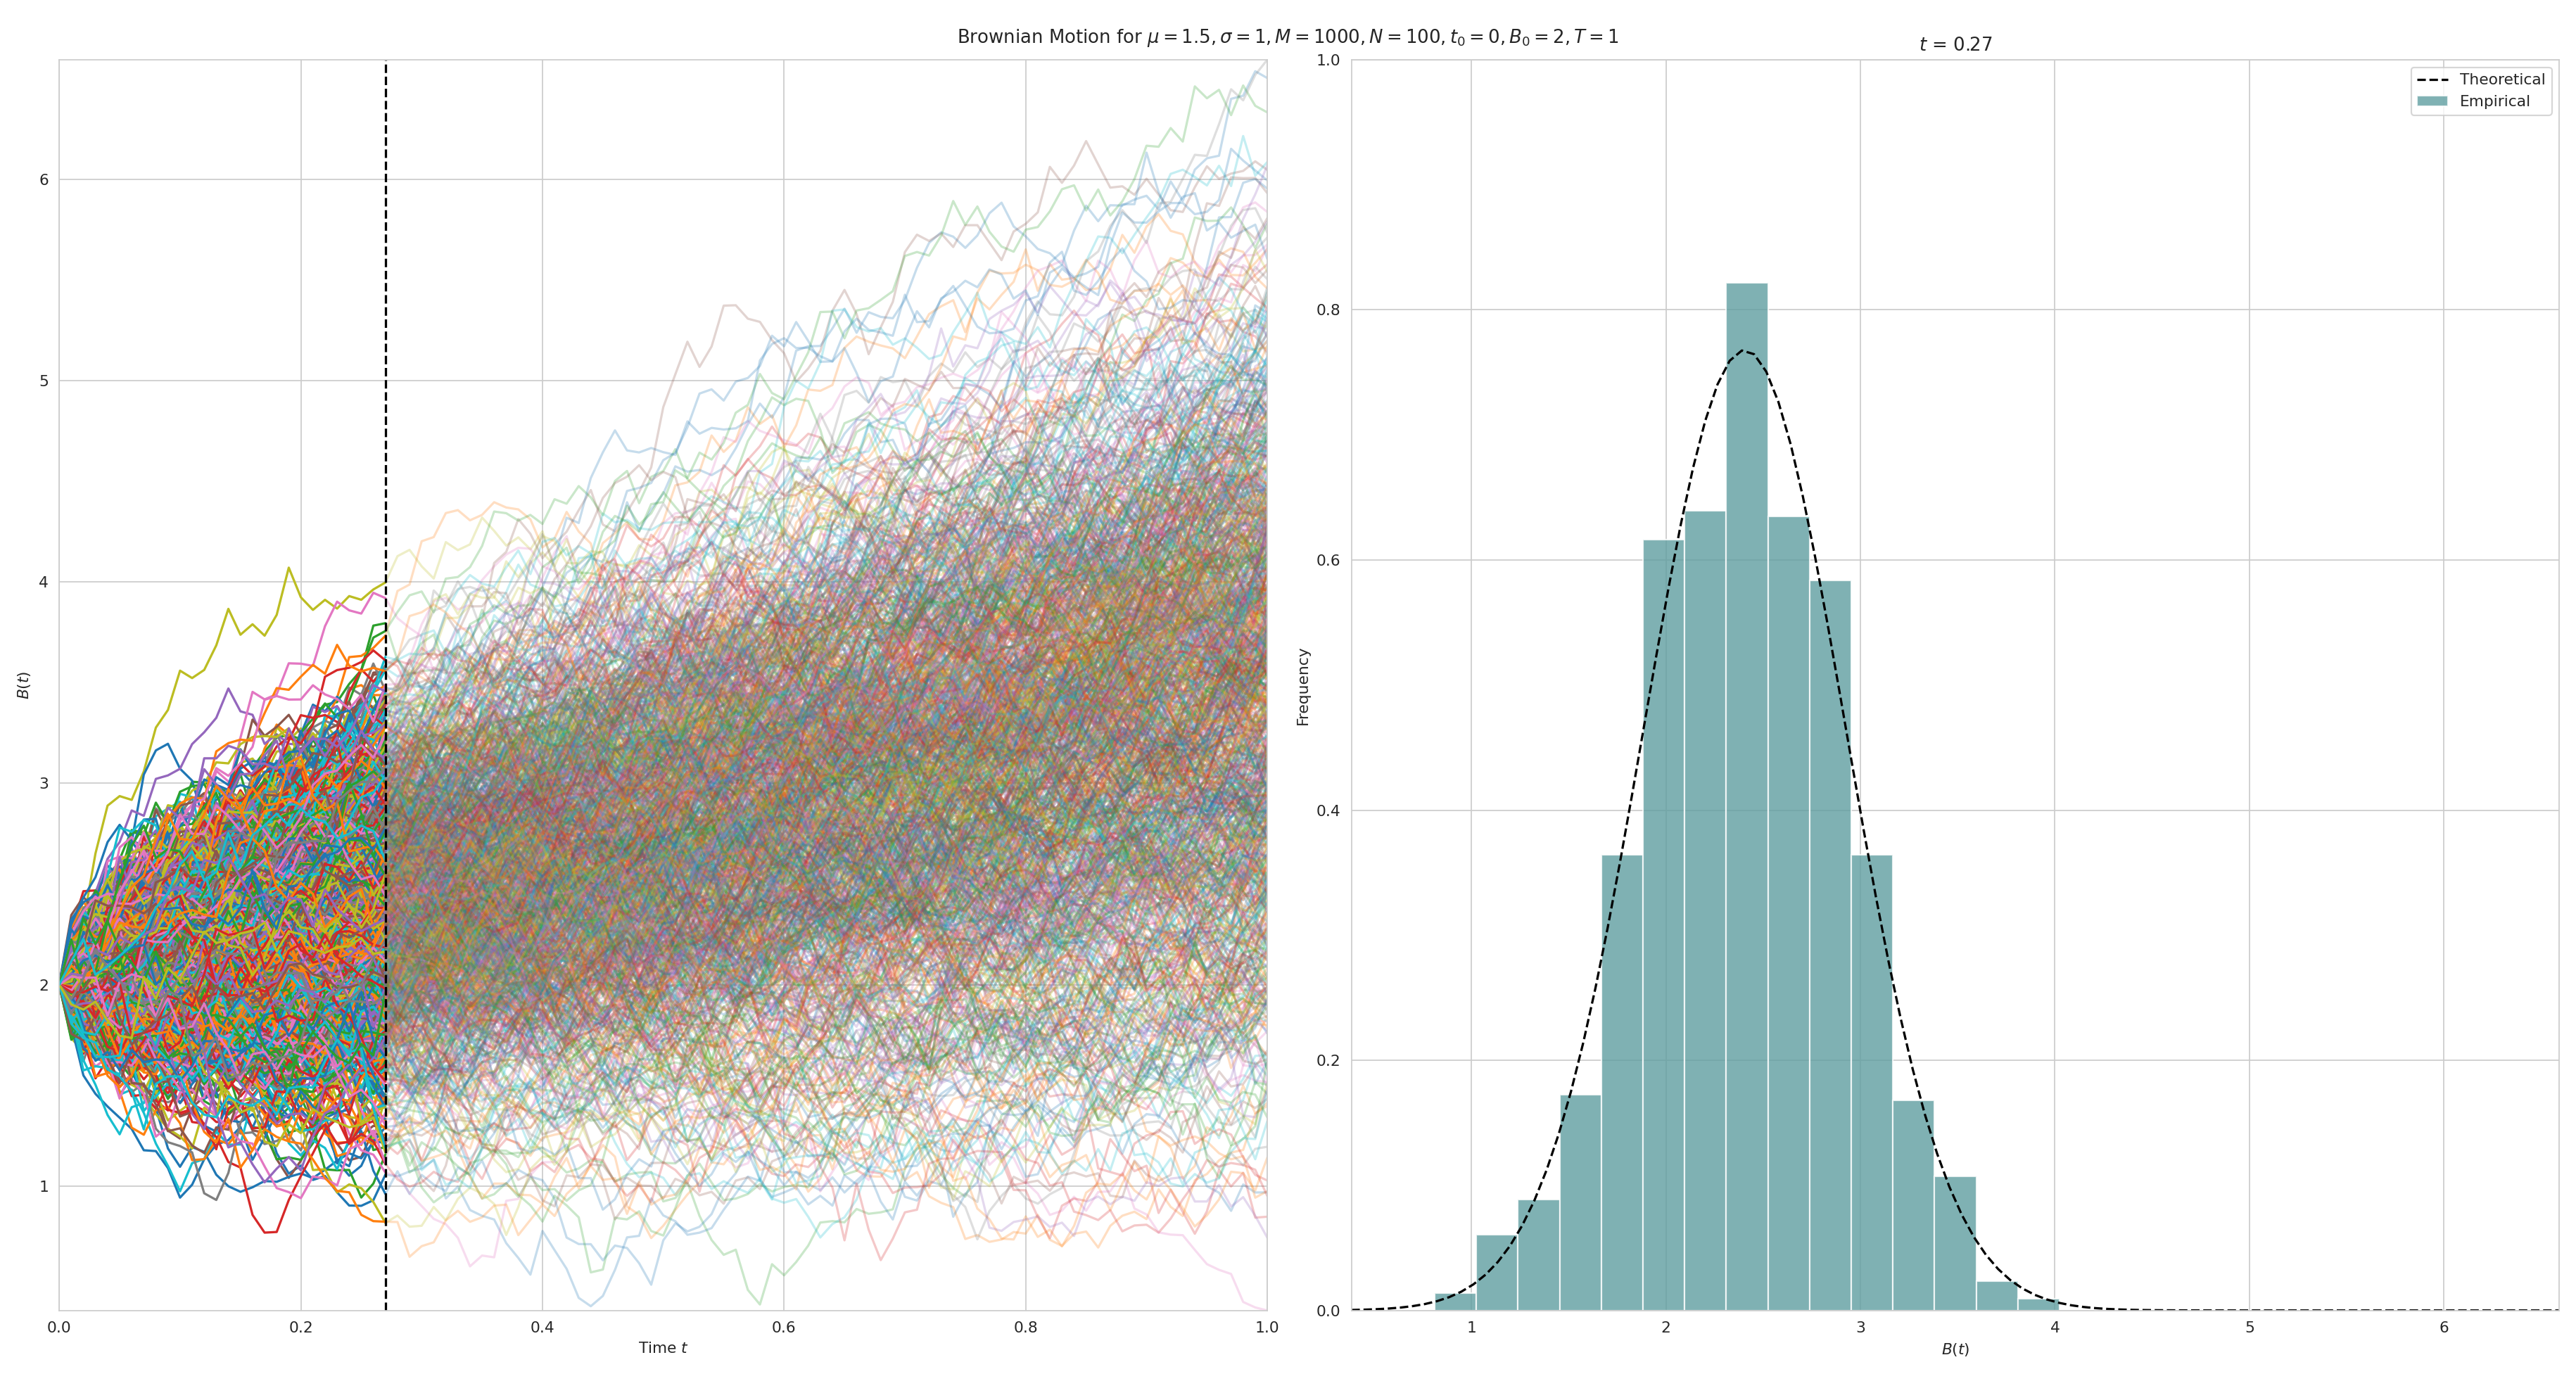

In [18]:
%matplotlib notebook

def move_animation(frame, ax, B, upper, lower, res1, res2):
    ax[0].cla()
    ax[1].cla()

    ax[0].set_xlabel(f'Time $t$')
    ax[0].set_ylabel(f'$B(t)$')

    ax[1].set_xlabel(f'$B(t)$')
    ax[1].set_ylabel('Frequency')

    ax[0].set_xlim(t0, t0 + T)
    ax[0].set_ylim(lower, upper)

    ax[1].set_xlim(lower, upper)
    ax[1].set_ylim(0, 1)

    plt.tight_layout()

    ax[0].plot(t[:frame+1], B[:, :frame+1].T)
    ax[0].plot(t[frame:], B[:, frame:].T, alpha=0.25)
    ax[0].axvline(t[frame], color='k', linestyle='--')

    ax[1].set_title(f'$t$ = {t[frame]:.2}')
    ax[1].hist([b[frame] for b in B], bins=res1, density=True, alpha=0.8, color = 'cadetblue', label=f'Empirical')

    if frame > 0:
        ax[1].plot(res2, stats.norm.pdf(res2, loc=B0 + mu*(t[frame]-t0), scale=sigma*np.sqrt(t[frame]-t0)), color='k', linestyle='--', label='Theoretical')
    else:
        ax[1].axhline(0, color='k', linestyle='--')
        ax[1].axvline(B0, color='k', linestyle='--')

    ax[1].legend()


sns.set_style('whitegrid')

mu, sigma = 1.5, 1

t0 = 0          # initial time
T = 1           # total length
B0 = 2          # initial point

M = 1000        # number of trajectories
N = 100         # number of steps

# Simulation
t, B = simulate_arithmetic_BM(t0, B0, T, mu, sigma, M, N)

# Animation parameters
lower, upper = np.min(B), np.max(B)
fig, ax = plt.subplots(1, 2, figsize=(15,8))
fig.suptitle(f'Brownian Motion for $\mu = {mu}, \sigma = {sigma}, M = {M}, N = {N}, t_0 = {t0}, B_0 = {B0}, T = {T}$')
res1, res2 = np.linspace(lower, upper, 30), np.linspace(lower, upper, 100)

# Brownian motion
gif = animation.FuncAnimation(fig, move_animation, N, fargs=(ax, B, upper, lower, res1, res2))
plt.show()